In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from datasets import Dataset
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

### Load data

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Second fine-tuning

In [20]:
# load the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.load_state_dict(torch.load("medical_modle.pth", weights_only=True))
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
waste_data = pd.read_csv("csv_data/waste_40.csv")

# get the length of section
print("Total number of texts: ", len(waste_data['text']))
print("Total number of labels: ", len(waste_data['label']))

#get number of papers per label
print("The number of papers per label are: ", waste_data['label'].value_counts(normalize=False))


Total number of texts:  40
Total number of labels:  40
The number of papers per label are:  label
1    20
0    20
Name: count, dtype: int64


In [22]:
# First split: 80% (train+val) and 20% (test)
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=44)
for train_idx, val_idx in split1.split(waste_data, waste_data['label']):
    waste_train_data = waste_data.iloc[train_idx]
    waste_val_data = waste_data.iloc[val_idx]


# Verify the splits on the labels
print("Train data: ", waste_train_data['label'].value_counts(normalize=False))
print()
print("Validation data: ", waste_val_data['label'].value_counts(normalize=False))
print()

Train data:  label
0    14
1    14
Name: count, dtype: int64

Validation data:  label
1    6
0    6
Name: count, dtype: int64



In [23]:
waste_train_dataset = Dataset.from_dict(waste_train_data.to_dict(orient='list'))
waste_val_dataset = Dataset.from_dict(waste_val_data.to_dict(orient='list'))


# Apply tokenization
waste_train_dataset = waste_train_dataset.map(tokenize_function, batched=True)
waste_val_dataset = waste_val_dataset.map(tokenize_function, batched=True)


# Set the format for PyTorch
waste_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
waste_val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

waste_model = model
# Training arguments
waste_training_args = TrainingArguments(
    output_dir="./temp",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir=None,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Matches the key in compute_metrics
    save_total_limit=2
)

# Define Trainer
waste_trainer = Trainer(
    model=waste_model,
    args=waste_training_args,
    train_dataset=waste_train_dataset,
    eval_dataset=waste_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
# Train the model
waste_trainer.train()

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.21157710254192352, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 0.2284, 'eval_samples_per_second': 52.543, 'eval_steps_per_second': 4.379, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.21563692390918732, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 0.242, 'eval_samples_per_second': 49.588, 'eval_steps_per_second': 4.132, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.23466342687606812, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 0.2328, 'eval_samples_per_second': 51.543, 'eval_steps_per_second': 4.295, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.2271522730588913, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 0.2507, 'eval_samples_per_second': 47.871, 'eval_steps_per_second': 3.989, 'epoch': 4.0}
{'loss': 0.7356, 'grad_norm': 6.248379230499268, 'learning_rate': 1e-05, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.1823587566614151, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 0.2009, 'eval_samples_per_second': 59.721, 'eval_steps_per_second': 4.977, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.18949221074581146, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 0.2438, 'eval_samples_per_second': 49.223, 'eval_steps_per_second': 4.102, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.1985330432653427, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 0.2399, 'eval_samples_per_second': 50.019, 'eval_steps_per_second': 4.168, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.1980421394109726, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 0.2369, 'eval_samples_per_second': 50.649, 'eval_steps_per_second': 4.221, 'epoch': 8.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.2001912146806717, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 0.2444, 'eval_samples_per_second': 49.098, 'eval_steps_per_second': 4.092, 'epoch': 9.0}
{'loss': 0.3482, 'grad_norm': 5.522457122802734, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.19523556530475616, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 0.2081, 'eval_samples_per_second': 57.655, 'eval_steps_per_second': 4.805, 'epoch': 10.0}
{'train_runtime': 36.5191, 'train_samples_per_second': 7.667, 'train_steps_per_second': 0.548, 'train_loss': 0.5418796539306641, 'epoch': 10.0}


TrainOutput(global_step=20, training_loss=0.5418796539306641, metrics={'train_runtime': 36.5191, 'train_samples_per_second': 7.667, 'train_steps_per_second': 0.548, 'total_flos': 37090871623680.0, 'train_loss': 0.5418796539306641, 'epoch': 10.0})

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

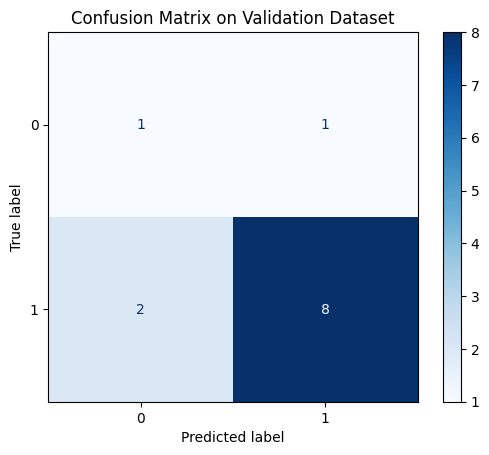

Accuracy: 0.7500
Precision: 0.7963
Recall: 0.7500
F1 Score: 0.7684


In [24]:
new_waste_data = pd.read_csv("csv_data/waste_12.csv")
waste_test_dataset = Dataset.from_dict(new_waste_data.to_dict(orient='list'))


# Apply tokenization
waste_test_dataset = waste_test_dataset.map(tokenize_function, batched=True)


# Set the format for PyTorch
waste_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
predictions = waste_trainer.predict(waste_test_dataset)

# Extract logits and true labels
logits = predictions.predictions
true_labels = predictions.label_ids
predicted_labels = np.argmax(logits, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=waste_model.config.id2label)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Dataset")
plt.show()
# print the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

## Below is to infer the pdfs in a folder

In [25]:
import os
import torch
import pandas as pd
import fitz  # PyMuPDF
def extract_text_from_pdf(pdf_path):
    try:
        doc = fitz.open(pdf_path)
        text = ""
        for page_num in range(doc.page_count):
            page = doc.load_page(page_num)
            text += page.get_text()
        return text
    except Exception as e:
        print(f"Error extracting text from {pdf_path}: {e}")
        return ""

def predict_label_for_pdf(pdf_path, model, tokenizer, device):
    # Extract text from the PDF
    text = extract_text_from_pdf(pdf_path)
    if not text.strip():
        print(f"No text extracted from {pdf_path}")
        return None

    # Tokenize the text
    inputs = tokenizer(
        text, 
        padding="max_length", 
        truncation=True, 
        max_length=512, 
        return_tensors="pt"
    )
    
    # Move tensors to the device (GPU or CPU)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Predict label
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()

    return predicted_label

def process_pdfs_after_training(directory_path, output_csv, model, tokenizer, device):
    results = []

    # Iterate through all PDF files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(directory_path, filename)
            print(f"Processing {filename}...")

            # Predict label for the PDF
            predicted_label = predict_label_for_pdf(pdf_path, model, tokenizer, device)
            
            if predicted_label is not None:
                results.append({"filename": filename, "predicted_label": predicted_label})

    # Save the results to a CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")

# Directory containing the PDFs
pdfs_dir = "pdf_data/test"
output_csv_path = "csv_data/test_predictions_2.csv"

# Run the process using the trained model
process_pdfs_after_training(
    directory_path=pdfs_dir,
    output_csv=output_csv_path,
    model=waste_model,       # The model you trained
    tokenizer=tokenizer,     # Tokenizer used during training
    device=device            # Device (GPU or CPU)
)

Processing abah 2022.pdf...
Processing abdurrahman 2020.pdf...
Processing adebiyi 2020.pdf...
Processing bajyacharya 2021.pdf...
Processing Das 2022.pdf...
Processing Lin 2013.pdf...
Processing tabian 2021.pdf...
Processing timonen 2021.pdf...
Processing uttajug 2021.pdf...
Processing uttajug 2022.pdf...
Processing vreeland 2016.pdf...
Processing wu 2006.pdf...
Processing zak 2021.pdf...
Processing zakey 2008.pdf...
Processing zalakeviciute 2020.pdf...
Processing zalakeviciute 2021.pdf...
Processing zalasiewicz 2019.pdf...
Processing zalel 2015.pdf...
Processing zalzal 2024.pdf...
Processing zhang 2023.pdf...
Predictions saved to csv_data/test_predictions_2.csv
